<a href="https://colab.research.google.com/github/riyabharath24/Handball-Action-Recognition/blob/main/Handball_Action_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

### ACTION RECOGNITION ON THE HANDBALL DATASET

In [ ]:
import tensorflow as tf

# Configure memory growth before any other TensorFlow operations
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


1. IMPORTING THE REQUIRED LIBRARIES

In [ ]:
%%capture

!pip install pafy youtube-dl moviepy
!pip install git+https://github.com/ytdl-org/youtube-dl.git@master#egg=youtube_dl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import the required libraries
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

#from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

2. VISUALIZING THE DATASET

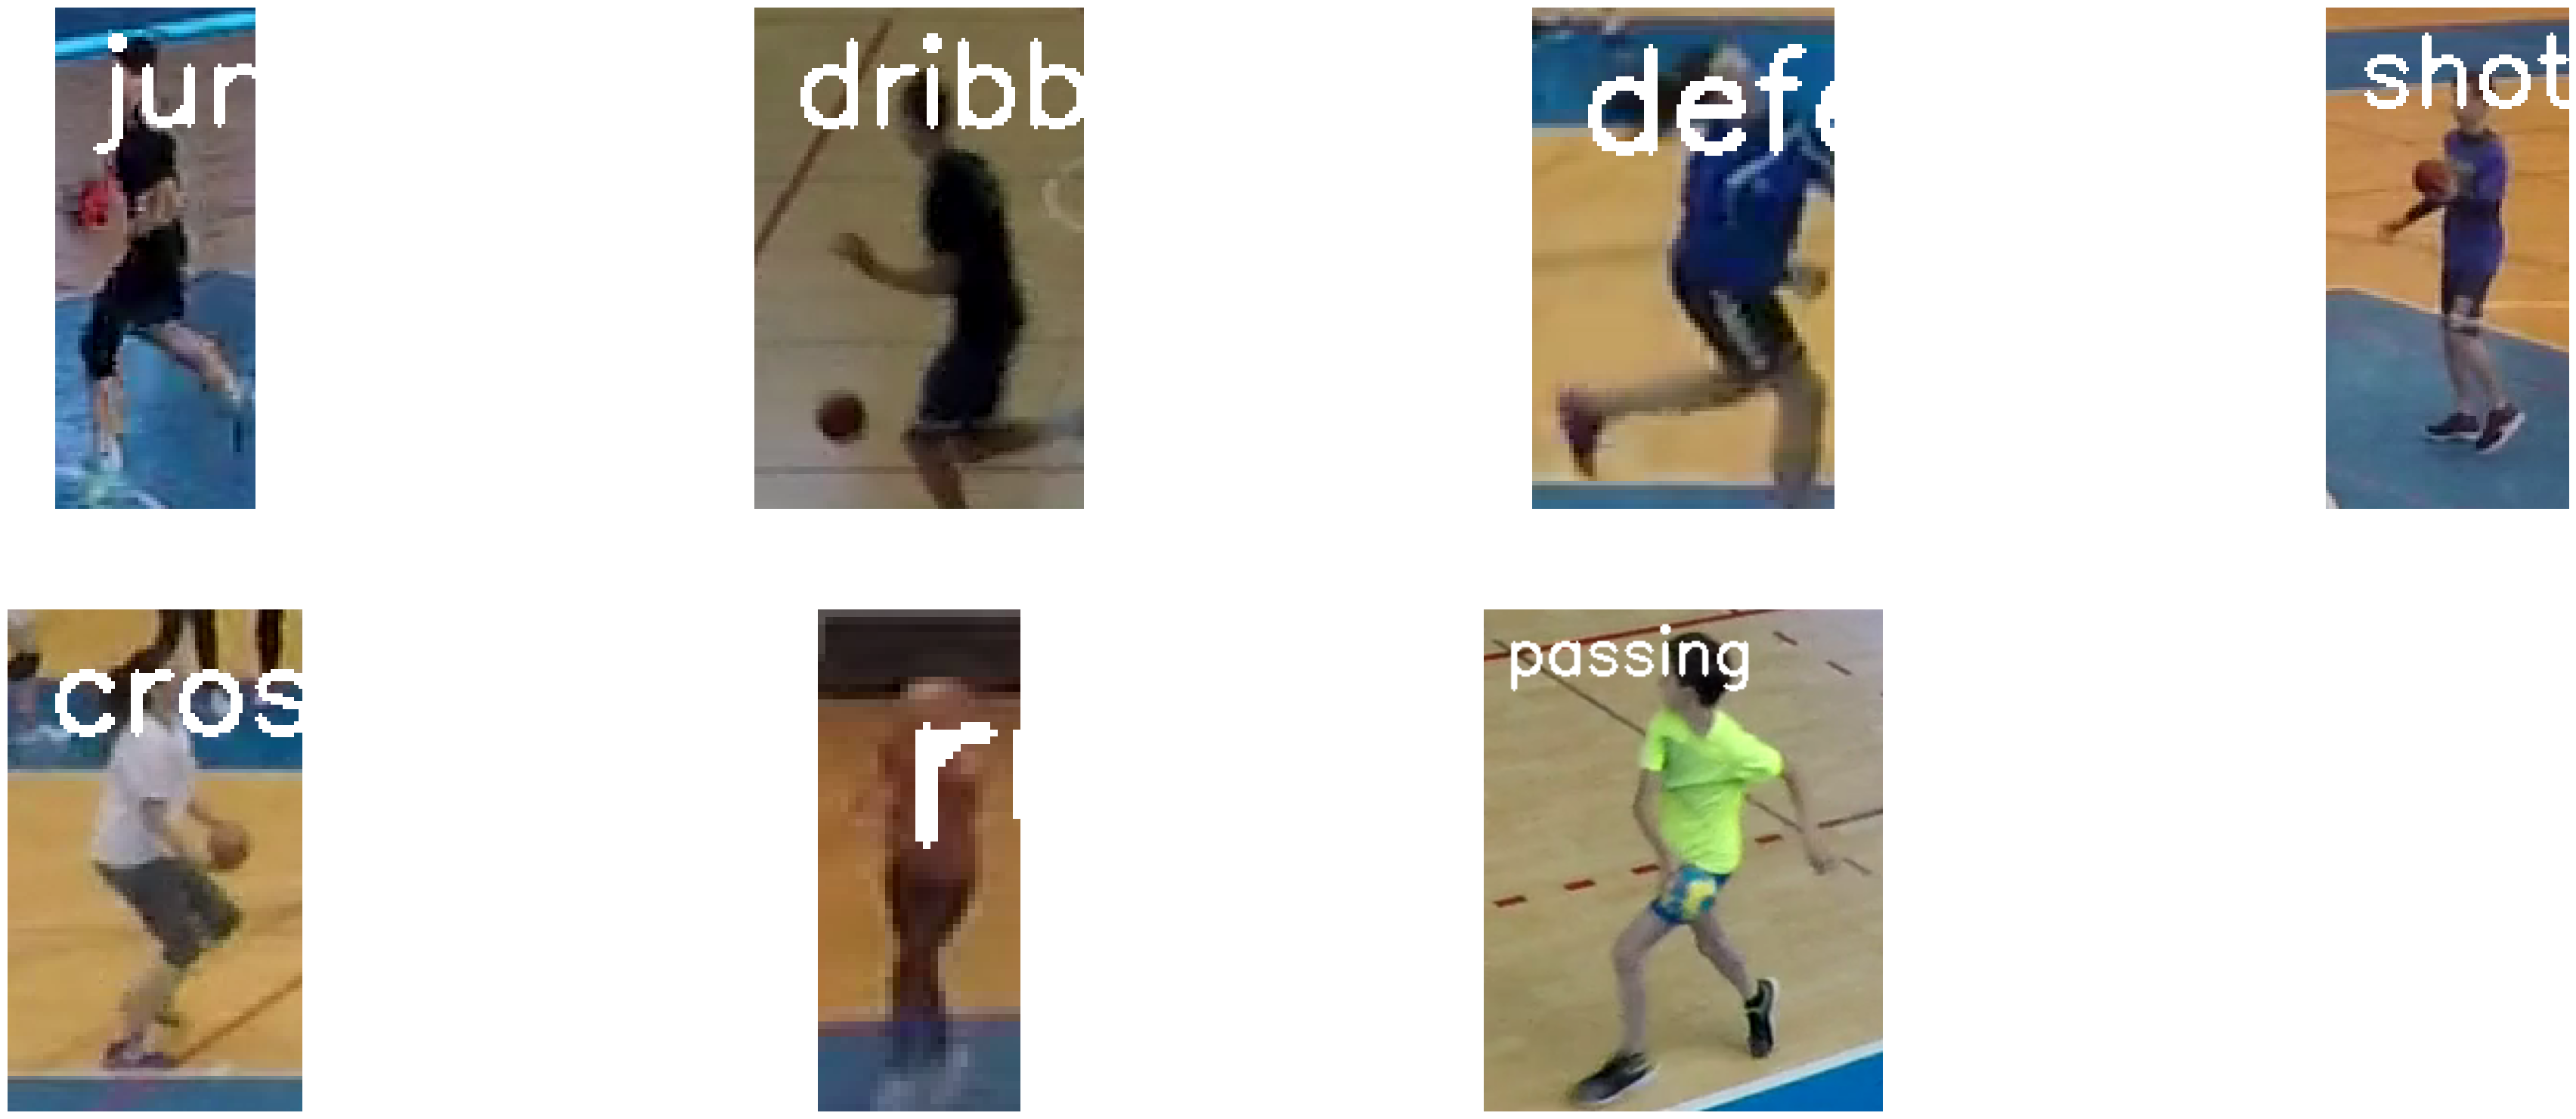

In [ ]:
plt.figure(figsize = (50,50))

all_classes_names = os.listdir('/content/drive/MyDrive/handball_project2/UNIRI-HBD/actions')

random_range = random.sample(range(len(all_classes_names)), 7)


for counter, random_index in enumerate(random_range, 1):

  selected_class_name = all_classes_names[random_index]

  video_files_names_list = os.listdir(f'/content/drive/MyDrive/handball_project2/UNIRI-HBD/actions/{selected_class_name}')

  selected_video_file_name = random.choice(video_files_names_list)

  video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/handball_project2/UNIRI-HBD/actions/{selected_class_name}/{selected_video_file_name}')

  #read the first frame of the video file
  _, bgr_frame = video_reader.read()

  #Release the VideoCapture object.
  video_reader.release()

  #Convert the frame from BGR into RGB format
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # Write the class name on the video frame
  cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

  # Display the frame
  plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')




### Preprocessing

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 20

DATASET_DIR = '/content/drive/MyDrive/handball_project2/UNIRI-HBD/actions'

CLASSES_LIST = ["jump-shot", "dribbling", "shot", "defence", "passing"]

In [ ]:
def frames_extraction(video_path):

  # Declare a list to store video frames.
  frames_list = []

  video_reader = cv2.VideoCapture(video_path)

  #Get the total number of frames in the video
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

  # Iterate through the video frames
  for frame_counter in range(SEQUENCE_LENGTH):

    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    success, frame = video_reader.read()

    # Check if Video frame is not successfully read then break the loop
    if not success:
      break

    # Resize the Frame to fixed height and width
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # Normalize the resized frame by dividing it with 255
    normalized_frame = resized_frame / 255

    #Append the normalized frame into the frames list
    frames_list.append(normalized_frame)

  # Release the VideoCapture object
  video_reader.release()

  # Return the frames list
  return frames_list

In [ ]:
def dataset_create():

    #Declare Empty Lists to store the features, labels and video file paths
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
      print(f'Extracting Data of Class: {class_name}')
      files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

      for file_name in files_list:
        video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
        frames = frames_extraction(video_file_path)

        if len(frames) == SEQUENCE_LENGTH:
          features.append(frames)
          labels.append(class_index)
          video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths


In [ ]:
# Creating the dataset
features, labels, video_files_paths = dataset_create()

Extracting Data of Class: jump-shot
Extracting Data of Class: dribbling
Extracting Data of Class: shot
Extracting Data of Class: defence
Extracting Data of Class: passing


In [ ]:
#Using Keras to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Splitting the Data into Train and Test sets
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model
LRCN_model = create_LRCN_model()

# Display the success message
print("Model Created Successfully!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,093 (285.52 KB)

 Trainable params: 73,093 (285.52 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=15, mode = 'min', restore_best_weights=True)

# Compile the model and specify loss function, optimizer and metrics to the model
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

# Start training the model
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size=4,
                                             shuffle=True, validation_split=0.2, callbacks = [early_stopping_callback])

Epoch 1/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.2947 - loss: 1.4708 - val_accuracy: 0.4146 - val_loss: 1.3874
Epoch 2/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3696 - loss: 1.3923 - val_accuracy: 0.4878 - val_loss: 1.1902
Epoch 3/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4833 - loss: 1.1758 - val_accuracy: 0.5122 - val_loss: 1.1099
Epoch 4/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5426 - loss: 1.0768 - val_accuracy: 0.3902 - val_loss: 1.3361
Epoch 5/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5798 - loss: 0.9622 - val_accuracy: 0.5732 - val_loss: 0.9494
Epoch 6/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6423 - loss: 0.8578 - val_accuracy: 0.6341 - val_loss: 0.9621
Epoch 7/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6249 - loss: 0.7984 - val_accuracy: 0.6951 - val_loss: 0.9463
Epoch 8/70
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6627 - loss: 0.7489 - val_accuracy: 0.6585 - 

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8159 - loss: 0.5359


In [ ]:
# Saving the model
# Get the loss and accuracy from model_evaluation_history
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Date and Time in a DateTime Object
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Defining a useful name for our model to make it easy for us while navigating
model_file_name = f'LRCN_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'
model_file_name = f'/content/drive/MyDrive/LRCN_models/{model_file_name}'

# Save the Model
LRCN_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

  # Getting metric values
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Construct a range object which will be used as x-axis
  epochs = range(len(metric_value_1))

  # Plot the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # Add title to the plot
  plt.title(str(plot_name))

  # Add legend to the plot
  plt.legend()

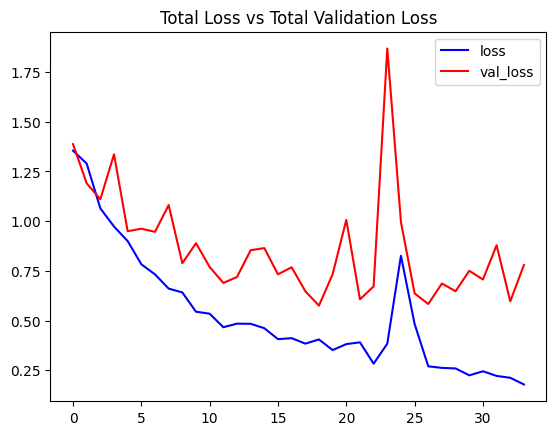

In [ ]:
# Visualize the training and validation loss metrices
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

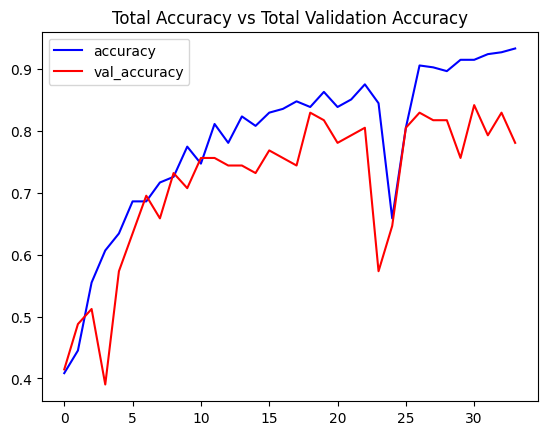

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Get the Video's path we just downloaded.
input_video_file_path = f'/content/drive/MyDrive/handball_project2/actions_2/track831_classdribbling.avi'


### Action Recognition on Videos

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

    print(f'Predicted Action : {predicted_class_name}')

    return frames_queue  # 🛑 Add this to return frames_queue


In [ ]:
from moviepy.editor import *

# Construct the output video path
output_video_file_path = f'{input_video_file_path}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video
frames_queue = predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

  if event.key is 'enter':



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Action : jump-shot
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:   0%|          | 0/30 [00:00<?, ?it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/handball_project2/actions_2/track831_classdribbling.avi-Output-SeqLen20.mp4, 270000 bytes wanted but 0 bytes read,at frame 29/30, at time 0.97/0.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                   

Moviepy - Done !
Moviepy - video ready __temp__.mp4


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


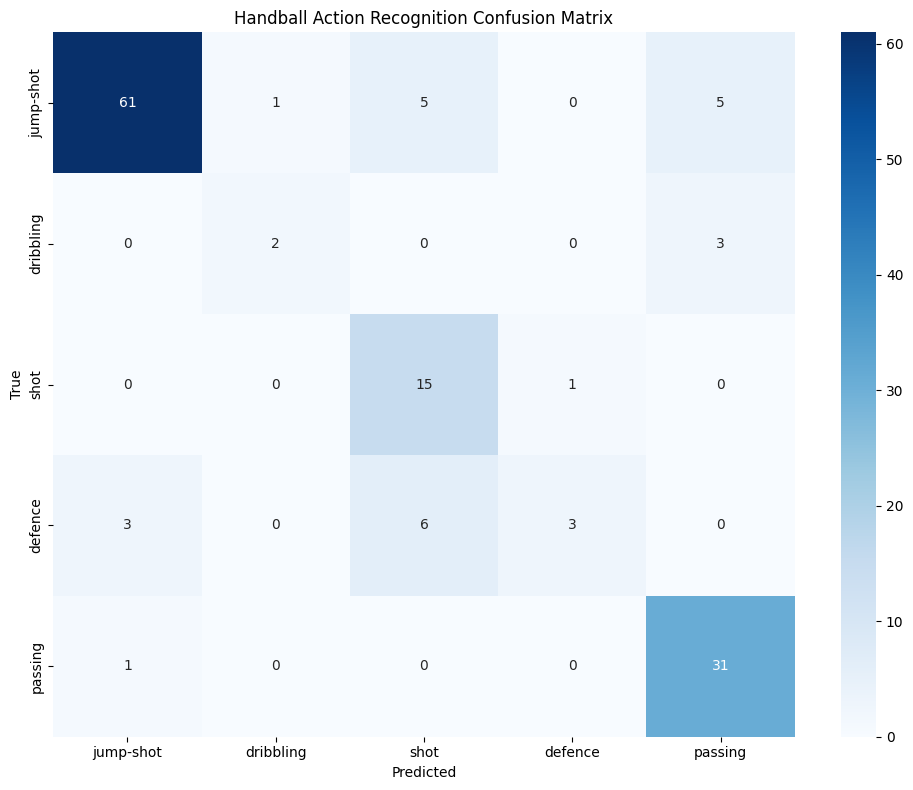

In [ ]:
# Implementation after model training
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on test set
y_pred = LRCN_model.predict(features_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(labels_test, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Handball Action Recognition Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

              precision    recall  f1-score   support

   jump-shot       0.94      0.85      0.89        72
   dribbling       0.67      0.40      0.50         5
        shot       0.58      0.94      0.71        16
     defence       0.75      0.25      0.38        12
     passing       0.79      0.97      0.87        32

    accuracy                           0.82       137
   macro avg       0.75      0.68      0.67       137
weighted avg       0.84      0.82      0.81       137



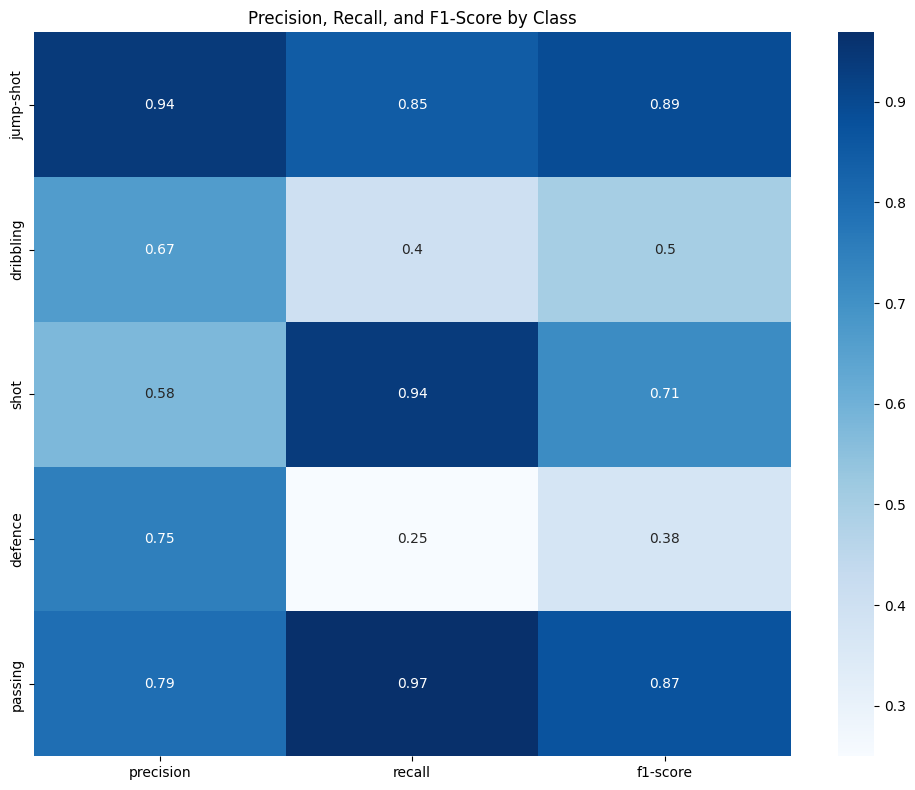

In [ ]:
from sklearn.metrics import classification_report

# Generate and print classification report
report = classification_report(y_true, y_pred_classes,
                              target_names=CLASSES_LIST,
                              output_dict=True)

# Print report
print(classification_report(y_true, y_pred_classes, target_names=CLASSES_LIST))

# Visualize as a heatmap
import pandas as pd
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 8))
sns.heatmap(report_df.iloc[:-3, :3].astype(float), annot=True, cmap='Blues')
plt.title('Precision, Recall, and F1-Score by Class')
plt.tight_layout()
plt.savefig('class_metrics.png')
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Top-1 Accuracy: 0.8175
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Top-2 Accuracy: 0.9124
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Top-3 Accuracy: 0.9927


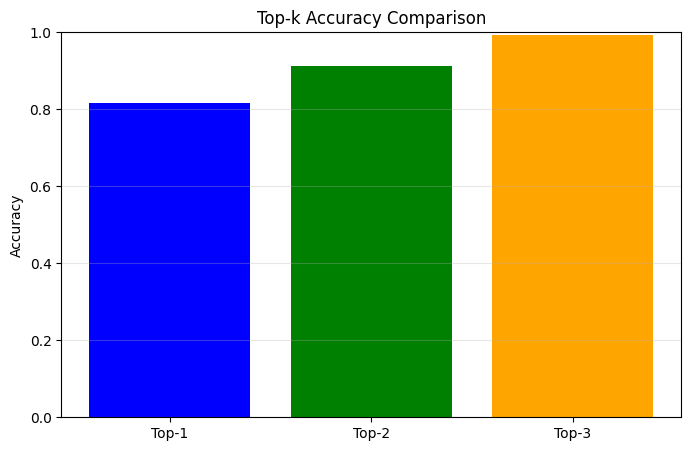

In [ ]:
def compute_top_k_accuracy(model, features, labels, k=2):
    """
    Compute top-k accuracy - whether the true label is in the top k predictions.
    """
    # Convert one-hot labels to class indices
    true_labels = np.argmax(labels, axis=1)

    # Get model predictions
    predictions = model.predict(features)

    # Get top k predicted classes for each sample
    top_k_pred = np.argsort(predictions, axis=1)[:, -k:]

    # Check if true label is in top k predictions for each sample
    matches = [true_labels[i] in top_k_pred[i] for i in range(len(true_labels))]

    # Compute accuracy
    top_k_accuracy = sum(matches) / len(matches)

    print(f"Top-{k} Accuracy: {top_k_accuracy:.4f}")

    return top_k_accuracy

# Example usage
top_1_acc = compute_top_k_accuracy(LRCN_model, features_test, labels_test, k=1)
top_2_acc = compute_top_k_accuracy(LRCN_model, features_test, labels_test, k=2)
top_3_acc = compute_top_k_accuracy(LRCN_model, features_test, labels_test, k=3)

# Plot results
plt.figure(figsize=(8, 5))
plt.bar(['Top-1', 'Top-2', 'Top-3'], [top_1_acc, top_2_acc, top_3_acc],
        color=['blue', 'green', 'orange'])
plt.ylim([0, 1.0])
plt.ylabel('Accuracy')
plt.title('Top-k Accuracy Comparison')
plt.grid(axis='y', alpha=0.3)
plt.savefig('top_k_accuracy.png')
plt.show()

In [ ]:
def evaluate_temporal_stability(model, video_path, window_size=SEQUENCE_LENGTH):
    """
    Evaluate how stable the model predictions are over time.
    Returns stability score (higher is more stable) and a list of predicted classes.
    """
    video_reader = cv2.VideoCapture(video_path)

    # Get video properties
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Initialize variables
    frames_queue = deque(maxlen=window_size)
    predictions = []
    frames_processed = 0

    # Process frames
    while video_reader.isOpened() and frames_processed < total_frames:
        success, frame = video_reader.read()
        if not success:
            break

        # Preprocess frame
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0

        # Add to queue
        frames_queue.append(normalized_frame)
        frames_processed += 1

        # Make prediction when queue is full
        if len(frames_queue) == window_size:
            input_data = np.array(frames_queue)
            input_data = np.expand_dims(input_data, axis=0)

            prediction = model.predict(input_data)
            predicted_class = np.argmax(prediction[0])
            predictions.append(predicted_class)

    # Release video resource
    video_reader.release()

    # Calculate stability metrics
    if len(predictions) <= 1:
        return 1.0, predictions  # Perfect stability if only one prediction

    # Count prediction changes
    changes = sum(1 for i in range(1, len(predictions))
                  if predictions[i] != predictions[i-1])

    # Calculate stability score
    stability_score = 1.0 - (changes / (len(predictions) - 1))

    # Create a histogram of predictions
    classes_counts = np.bincount(predictions, minlength=len(CLASSES_LIST))
    dominant_class = np.argmax(classes_counts)
    dominant_class_percentage = classes_counts[dominant_class] / len(predictions)

    # Plot predictions over time
    plt.figure(figsize=(12, 6))
    plt.plot(predictions, '-o', markersize=4)
    plt.yticks(range(len(CLASSES_LIST)), CLASSES_LIST)
    plt.xlabel('Frame Number')
    plt.ylabel('Predicted Class')
    plt.title(f'Prediction Stability - Score: {stability_score:.4f}')
    plt.grid(True, axis='y')
    plt.savefig(f"stability_{os.path.basename(video_path)}.png")
    plt.show()

    return stability_score, predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


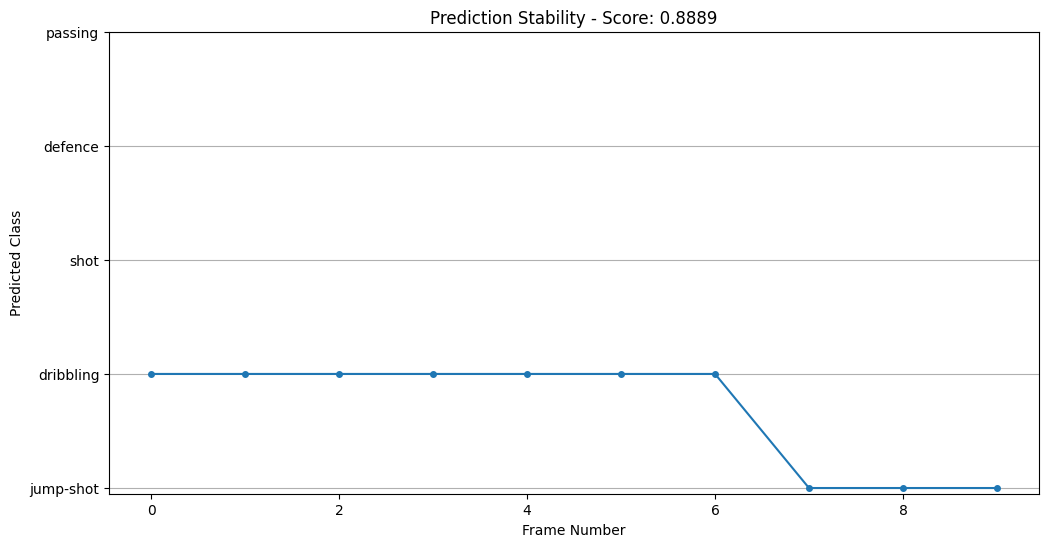

Stability Score: 0.8889


In [ ]:
# Run the stability evaluation
stability_score, predictions = evaluate_temporal_stability(
    model=LRCN_model,
    video_path=input_video_file_path,
    window_size=20  # Use the same value as SEQUENCE_LENGTH in your model
)

print(f"Stability Score: {stability_score:.4f}")

Evaluating: track781_classdefence.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


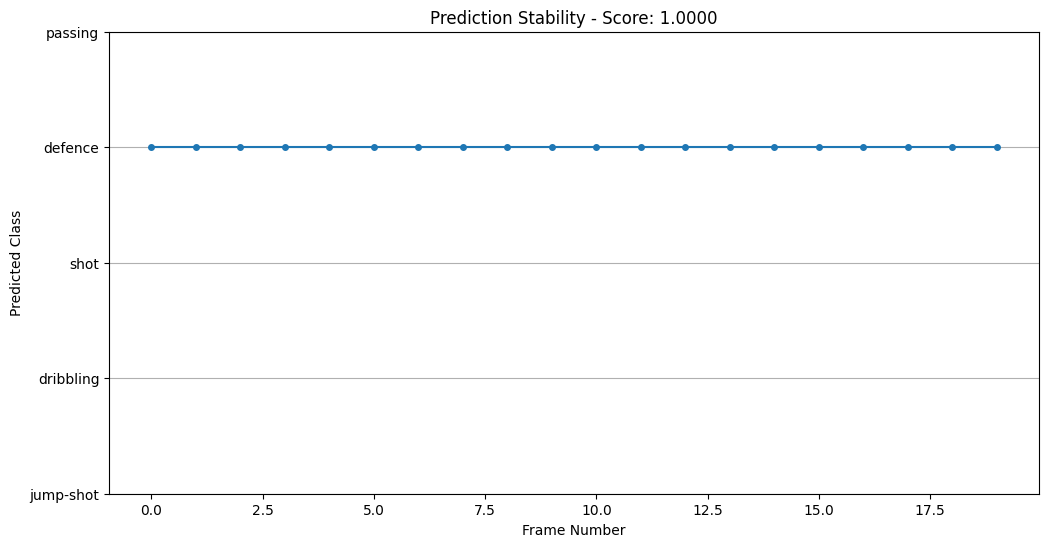

Evaluating: track831_classdribbling.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


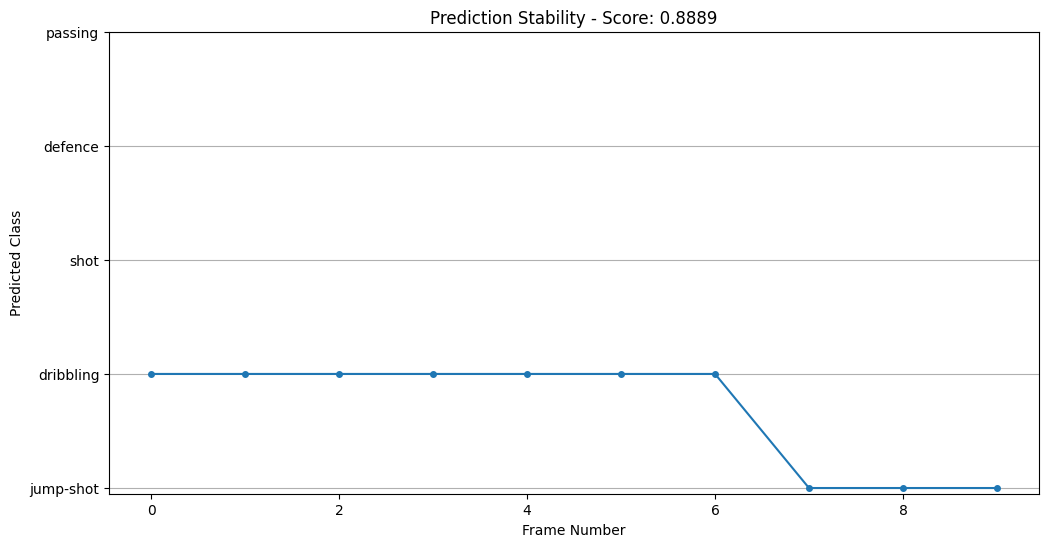

Evaluating: track915_classjump-shot.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━

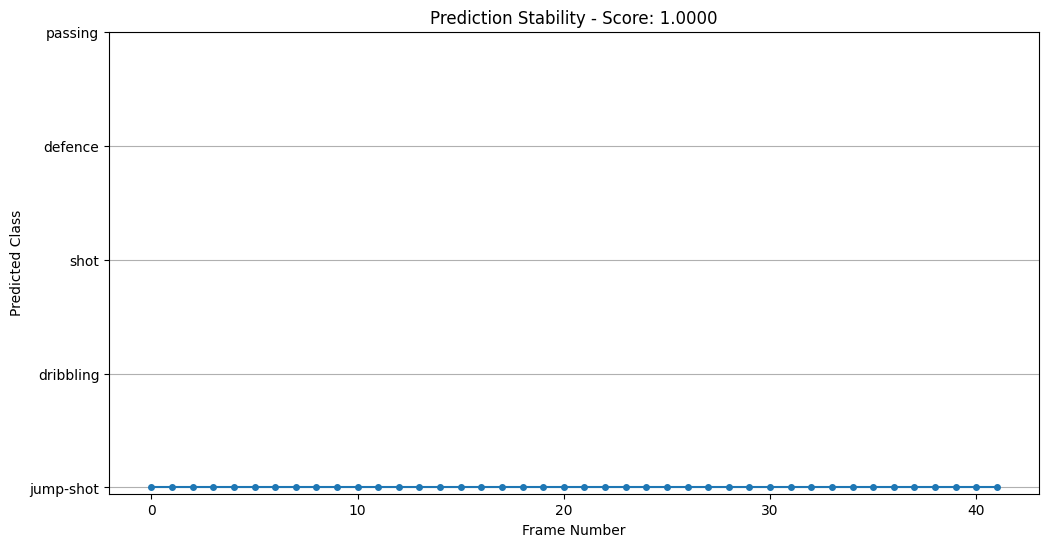

Evaluating: track2291_classpassing.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

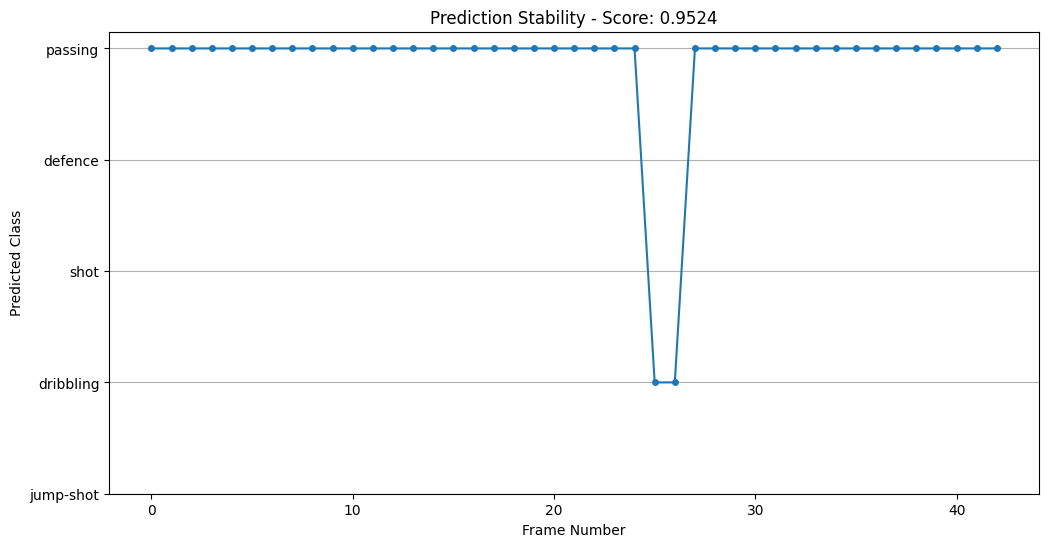

Evaluating: track2873_classshot.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━

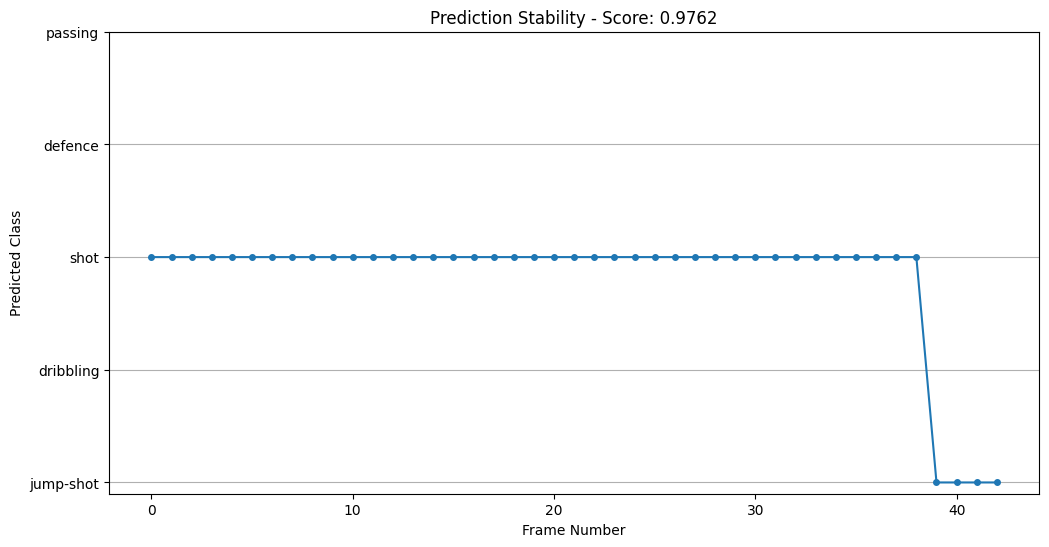

Evaluating: track781_classdefence.avi-Output-SeqLen20.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


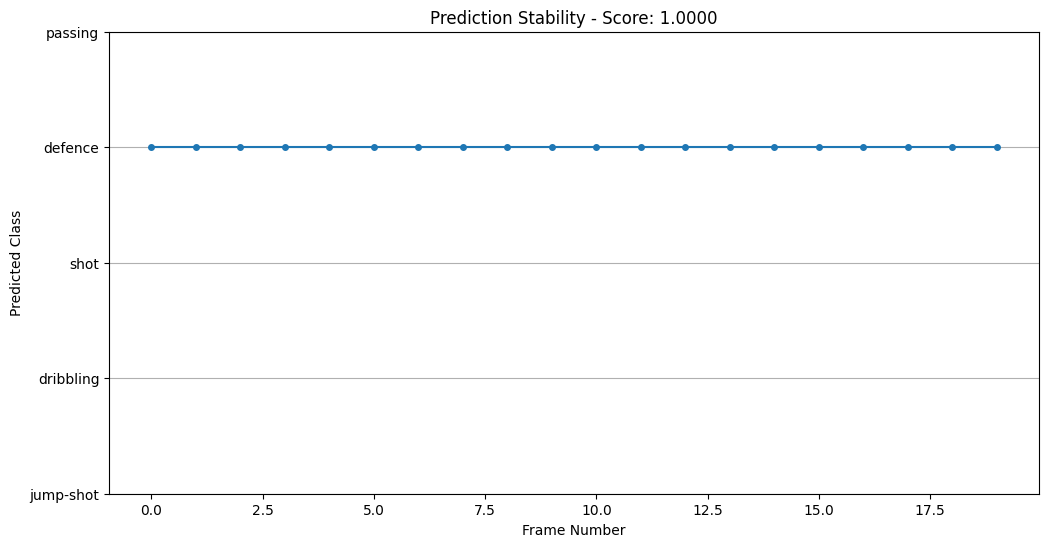

Evaluating: track915_classjump-shot.avi-Output-SeqLen20.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

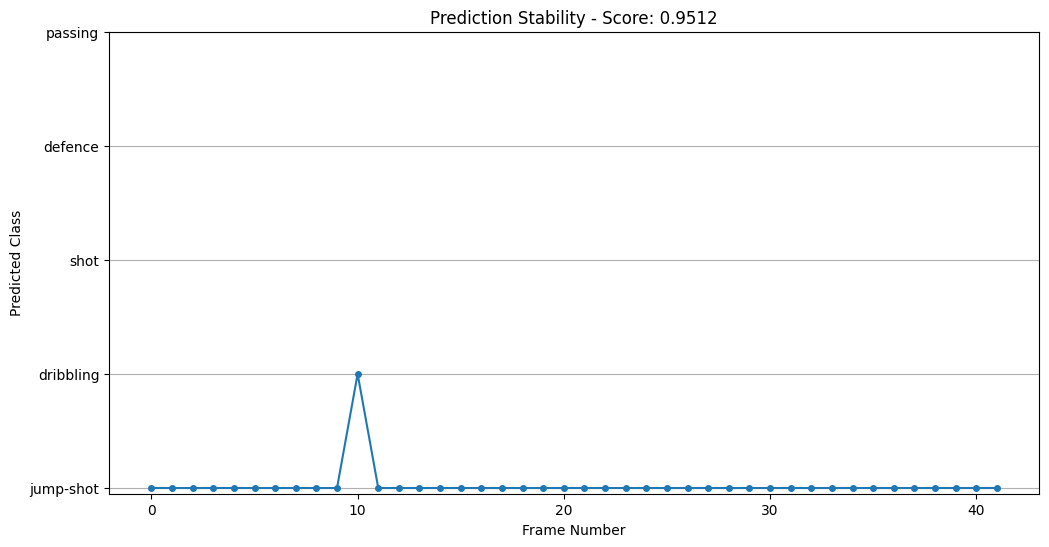

Evaluating: track831_classdribbling.avi-Output-SeqLen20.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


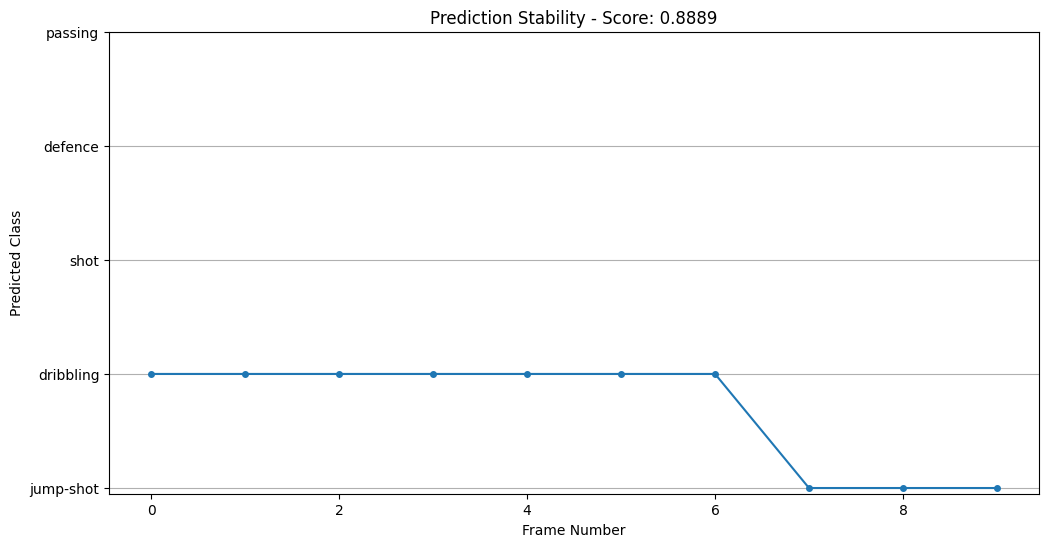

Video: track781_classdefence.avi, Stability: 1.0000
Video: track831_classdribbling.avi, Stability: 0.8889
Video: track915_classjump-shot.avi, Stability: 1.0000
Video: track2291_classpassing.avi, Stability: 0.9524
Video: track2873_classshot.avi, Stability: 0.9762
Video: track781_classdefence.avi-Output-SeqLen20.mp4, Stability: 1.0000
Video: track915_classjump-shot.avi-Output-SeqLen20.mp4, Stability: 0.9512
Video: track831_classdribbling.avi-Output-SeqLen20.mp4, Stability: 0.8889


In [ ]:
# If you want to evaluate multiple videos
video_folder = "/content/drive/MyDrive/handball_project2/actions_2"
video_files = [f for f in os.listdir(video_folder) if f.endswith(('.mp4', '.avi'))]

results = {}
for video_file in video_files:
    full_path = os.path.join(video_folder, video_file)
    print(f"Evaluating: {video_file}")

    stability_score, predictions = evaluate_temporal_stability(
        model=LRCN_model,
        video_path=full_path
    )

    results[video_file] = {
        'stability_score': stability_score,
        'predictions': predictions
    }

# Compare stability across videos
for video, data in results.items():
    print(f"Video: {video}, Stability: {data['stability_score']:.4f}")

In [ ]:
def identify_key_frames(model, video_path, window_size=SEQUENCE_LENGTH):
    """
    Identify frames that cause the model to change its prediction.
    These are likely the key moments in action transitions.
    """
    video_reader = cv2.VideoCapture(video_path)

    # Get video properties
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Initialize variables
    frames_queue = deque(maxlen=window_size)
    predictions = []
    frames_list = []
    frame_indices = []

    # Process frames
    for frame_idx in range(total_frames):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        success, frame = video_reader.read()
        if not success:
            break

        # Store original frame for visualization
        frames_list.append(frame.copy())
        frame_indices.append(frame_idx)

        # Preprocess frame
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0

        # Add to queue
        frames_queue.append(normalized_frame)

        # Make prediction when queue is full
        if len(frames_queue) == window_size:
            # Convert queue to numpy array
            input_data = np.array(frames_queue)
            input_data = np.expand_dims(input_data, axis=0)

            # Predict and save class
            prediction = model.predict(input_data)
            predicted_class = np.argmax(prediction[0])
            predictions.append(predicted_class)

    # Release video resource
    video_reader.release()

    # Find frames where prediction changes
    key_frame_indices = []
    if len(predictions) > 1:
        for i in range(1, len(predictions)):
            if predictions[i] != predictions[i-1]:
                # The key frame is likely within the last few frames
                # that caused the prediction to change
                key_frame_idx = frame_indices[i + window_size - 1]
                key_frame_indices.append(key_frame_idx)

    # Display key frames
    if key_frame_indices:
        plt.figure(figsize=(15, 10))
        for i, idx in enumerate(key_frame_indices[:9]):  # Show up to 9 key frames
            if i >= 9:
                break

            # Find the closest stored frame
            closest_idx = min(range(len(frame_indices)),
                             key=lambda j: abs(frame_indices[j] - idx))

            # Show frame and the before/after predictions
            pred_idx = closest_idx - window_size + 1
            if 0 <= pred_idx < len(predictions) - 1:
                before_class = CLASSES_LIST[predictions[pred_idx]]
                after_class = CLASSES_LIST[predictions[pred_idx + 1]]

                plt.subplot(3, 3, i + 1)
                plt.imshow(cv2.cvtColor(frames_list[closest_idx], cv2.COLOR_BGR2RGB))
                plt.title(f"Frame {idx}\n{before_class} → {after_class}")
                plt.axis('off')

        plt.tight_layout()
        plt.suptitle("Key Frames Where Prediction Changes", fontsize=16)
        plt.subplots_adjust(top=0.9)
        plt.savefig("key_frames.png")
        plt.show()

        print(f"Found {len(key_frame_indices)} key frames where prediction changes")
    else:
        print("No key frames found (prediction remained stable)")

    return key_frame_indices

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


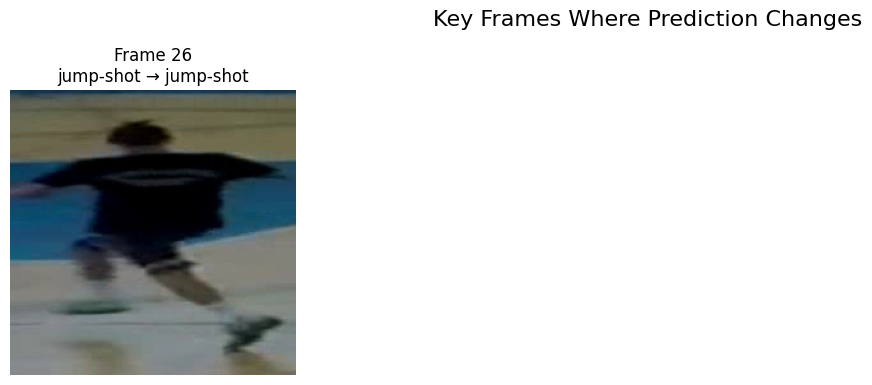

Found 1 key frames where prediction changes


[26]

In [ ]:
identify_key_frames(LRCN_model, input_video_file_path)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.ndimage import gaussian_filter

# --- Configuration ---
INPUT_FOLDER = '/content/drive/MyDrive/handball_project2/actions_2'  # Folder with .avi files
OUTPUT_FOLDER = '/content/drive//MyDrive/handball_project2/gradcam_all_videos'
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
CLASSES_LIST = ["jump-shot", "dribbling", "shot", "defence", "passing"]

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# --- Grad-CAM Functions (no change needed) ---
def apply_gradcam_to_frame_sequence(model, frame_sequence, class_idx=None):
    with tf.GradientTape() as tape:
        inputs = tf.Variable(frame_sequence)
        preds = model(inputs)
        if class_idx is None:
            class_idx = tf.argmax(preds[0])
        confidence = preds[0, class_idx].numpy()
        loss = preds[0, class_idx]
    grads = tape.gradient(loss, inputs)
    first_frame_grads = grads[0, 0].numpy()
    grad_magnitude = np.sum(np.abs(first_frame_grads), axis=-1)
    grad_magnitude = gaussian_filter(grad_magnitude, sigma=2)
    grad_magnitude -= np.min(grad_magnitude)
    grad_magnitude /= (np.max(grad_magnitude) + 1e-8)
    grad_magnitude = np.power(grad_magnitude, 0.5)
    return grad_magnitude, class_idx, confidence

def save_and_display_gradcam_enhanced(img, heatmap, save_path, alpha=0.7):
    img = np.uint8(img * 255.0)
    heatmap = np.uint8(255 * heatmap)
    colormap = plt.cm.get_cmap("hot")
    colored = colormap(np.arange(256))[:, :3]
    heatmap_color = colored[heatmap].reshape((img.shape[0], img.shape[1], 3))
    overlay = np.uint8(heatmap_color * alpha + img * (1 - alpha))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Original"); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(heatmap, cmap='hot'); plt.title("Attention Heatmap"); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay"); plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# --- Process All Videos ---
def apply_gradcam_to_all_videos(model, input_dir, output_dir, num_frames=3):
    video_files = [f for f in os.listdir(input_dir) if f.endswith('.avi')]
    for video_file in video_files:
        video_path = os.path.join(input_dir, video_file)
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
        video_name = os.path.splitext(video_file)[0]
        video_output_dir = os.path.join(output_dir, video_name)
        os.makedirs(video_output_dir, exist_ok=True)

        for i, frame_idx in enumerate(frame_indices):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            success, frame = cap.read()
            if not success:
                print(f"❌ Could not read frame {frame_idx} in {video_file}")
                continue
            resized = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
            normalized = resized / 255.0
            frames_seq = np.expand_dims([normalized] * SEQUENCE_LENGTH, axis=0)

            try:
                heatmap, class_idx, confidence = apply_gradcam_to_frame_sequence(model, frames_seq)
                class_name = CLASSES_LIST[class_idx]
                save_path = os.path.join(video_output_dir, f"frame{frame_idx}_{class_name}_{confidence:.2f}.png")
                save_and_display_gradcam_enhanced(normalized, heatmap, save_path)
                print(f"✅ Saved Grad-CAM for {video_file}, frame {frame_idx}, class: {class_name}")
            except Exception as e:
                print(f"⚠️ Error processing {video_file}, frame {frame_idx}: {e}")

        cap.release()

# --- Call the function ---
apply_gradcam_to_all_videos(model=LRCN_model, input_dir=INPUT_FOLDER, output_dir=OUTPUT_FOLDER)


  colormap = plt.cm.get_cmap("hot")



✅ Saved Grad-CAM for track781_classdefence.avi, frame 0, class: defence
✅ Saved Grad-CAM for track781_classdefence.avi, frame 19, class: defence
✅ Saved Grad-CAM for track781_classdefence.avi, frame 38, class: defence
✅ Saved Grad-CAM for track831_classdribbling.avi, frame 0, class: dribbling
✅ Saved Grad-CAM for track831_classdribbling.avi, frame 14, class: dribbling
✅ Saved Grad-CAM for track831_classdribbling.avi, frame 28, class: dribbling
✅ Saved Grad-CAM for track915_classjump-shot.avi, frame 0, class: jump-shot
✅ Saved Grad-CAM for track915_classjump-shot.avi, frame 30, class: jump-shot
✅ Saved Grad-CAM for track915_classjump-shot.avi, frame 60, class: jump-shot
✅ Saved Grad-CAM for track2291_classpassing.avi, frame 0, class: passing
✅ Saved Grad-CAM for track2291_classpassing.avi, frame 30, class: passing
✅ Saved Grad-CAM for track2291_classpassing.avi, frame 61, class: passing
✅ Saved Grad-CAM for track2873_classshot.avi, frame 0, class: jump-shot
✅ Saved Grad-CAM for track287

In [ ]:
def run_gradient_visualization():
    """
    Run a simple gradient-based visualization that works reliably.
    """
    # 1. Load a sample video frame
    video_path = '/content/drive/MyDrive/handball_project2/actions_2/track2873_classshot.avi'
    video = cv2.VideoCapture(video_path)
    success, frame = video.read()
    video.release()

    if not success:
        print("Failed to read video")
        return

    # 2. Preprocess the frame
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255.0

    # 3. Create a sequence by duplicating the frame
    frames_sequence = np.array([normalized_frame] * SEQUENCE_LENGTH)
    frames_sequence = np.expand_dims(frames_sequence, axis=0)

    # 4. Get model prediction
    prediction = LRCN_model.predict(frames_sequence)
    predicted_class_idx = np.argmax(prediction[0])
    predicted_class = CLASSES_LIST[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx]

    print(f"Model predicts: {predicted_class} with {confidence:.4f} confidence")

    # 5. Calculate gradients manually without tf.function
    # Convert to TensorFlow Variable
    input_var = tf.Variable(frames_sequence)

    with tf.GradientTape() as tape:
        # Forward pass
        preds = LRCN_model(input_var)
        target_output = preds[0, predicted_class_idx]

    # Get gradients
    grads = tape.gradient(target_output, input_var)

    # Convert to numpy for visualization
    grads_np = grads.numpy()

    # 6. Use the first frame for visualization
    first_frame_grads = grads_np[0, 0]

    # 7. Calculate magnitude and normalize
    grad_magnitude = np.sum(np.abs(first_frame_grads), axis=-1)
    grad_magnitude = grad_magnitude / np.max(grad_magnitude)

    # 8. Apply Gaussian smoothing for better visualization
    from scipy.ndimage import gaussian_filter
    grad_magnitude_smooth = gaussian_filter(grad_magnitude, sigma=1.0)

    # 9. Visualize
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(normalized_frame)
    plt.title('Original Frame')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(grad_magnitude_smooth, cmap='hot')
    plt.title(f'Importance Heatmap\nClass: {predicted_class}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(normalized_frame)
    plt.imshow(grad_magnitude_smooth, cmap='hot', alpha=0.7)
    plt.title('Overlay Visualization')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('handball_importance_map.png')
    plt.show()

    return grad_magnitude_smooth

# Call the visualization function
importance_map = run_gradient_visualization()

In [ ]:
def visualize_all_action_classes():
    """
    Visualize what the model looks for in each handball action class.
    """
    # Load a sample video frame
    video_path = '/content/drive/MyDrive/handball_project2/actions_2/track2873_classshot.avi'
    video = cv2.VideoCapture(video_path)
    success, frame = video.read()
    video.release()

    if not success:
        print("Failed to read video")
        return

    # Preprocess the frame
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255.0

    # Create a sequence
    frames_sequence = np.array([normalized_frame] * SEQUENCE_LENGTH)
    frames_sequence = np.expand_dims(frames_sequence, axis=0)

    # Get model prediction
    prediction = LRCN_model.predict(frames_sequence)
    predicted_class_idx = np.argmax(prediction[0])
    predicted_class = CLASSES_LIST[predicted_class_idx]

    print(f"Original prediction: {predicted_class} (confidence: {prediction[0][predicted_class_idx]:.4f})")

    # Results container
    importance_maps = {}

    # Calculate gradients for each class
    for class_idx, class_name in enumerate(CLASSES_LIST):
        print(f"Analyzing class: {class_name}")

        # Convert to TensorFlow Variable
        input_var = tf.Variable(frames_sequence)

        with tf.GradientTape() as tape:
            # Forward pass
            preds = LRCN_model(input_var)
            target_output = preds[0, class_idx]

        # Get gradients
        grads = tape.gradient(target_output, input_var)

        # First frame gradients
        first_frame_grads = grads.numpy()[0, 0]

        # Calculate magnitude and normalize
        grad_magnitude = np.sum(np.abs(first_frame_grads), axis=-1)
        grad_magnitude = grad_magnitude / np.max(grad_magnitude)

        # Apply Gaussian smoothing for better visualization
        from scipy.ndimage import gaussian_filter
        grad_magnitude_smooth = gaussian_filter(grad_magnitude, sigma=1.0)

        # Store result
        importance_maps[class_name] = {
            'map': grad_magnitude_smooth,
            'confidence': prediction[0][class_idx]
        }

    # Visualize all classes
    plt.figure(figsize=(15, 3 * len(CLASSES_LIST)))

    for i, (class_name, data) in enumerate(importance_maps.items()):
        heatmap = data['map']
        confidence = data['confidence']

        # Original image
        plt.subplot(len(CLASSES_LIST), 3, i*3+1)
        plt.imshow(normalized_frame)
        if class_name == predicted_class:
            plt.title(f'{class_name} (PREDICTED)\nConfidence: {confidence:.4f}')
        else:
            plt.title(f'{class_name}\nConfidence: {confidence:.4f}')
        plt.axis('off')

        # Heatmap
        plt.subplot(len(CLASSES_LIST), 3, i*3+2)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Importance Heatmap')
        plt.axis('off')

        # Overlay
        plt.subplot(len(CLASSES_LIST), 3, i*3+3)
        plt.imshow(normalized_frame)
        plt.imshow(heatmap, cmap='hot', alpha=0.7)
        plt.title('Overlay')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('handball_all_classes_visualization.png')
    plt.show()

    return importance_maps

# Call the function to visualize all action classes
all_class_maps = visualize_all_action_classes()

Installing LIME...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 754.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7e1351d1bf066ac3a72c5945ff764a72d8e23d39348e666fc81219faca246e07
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Explaining prediction: dribbling with confidence 0.7033
Generating LIME explanation (this may take a minute)...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

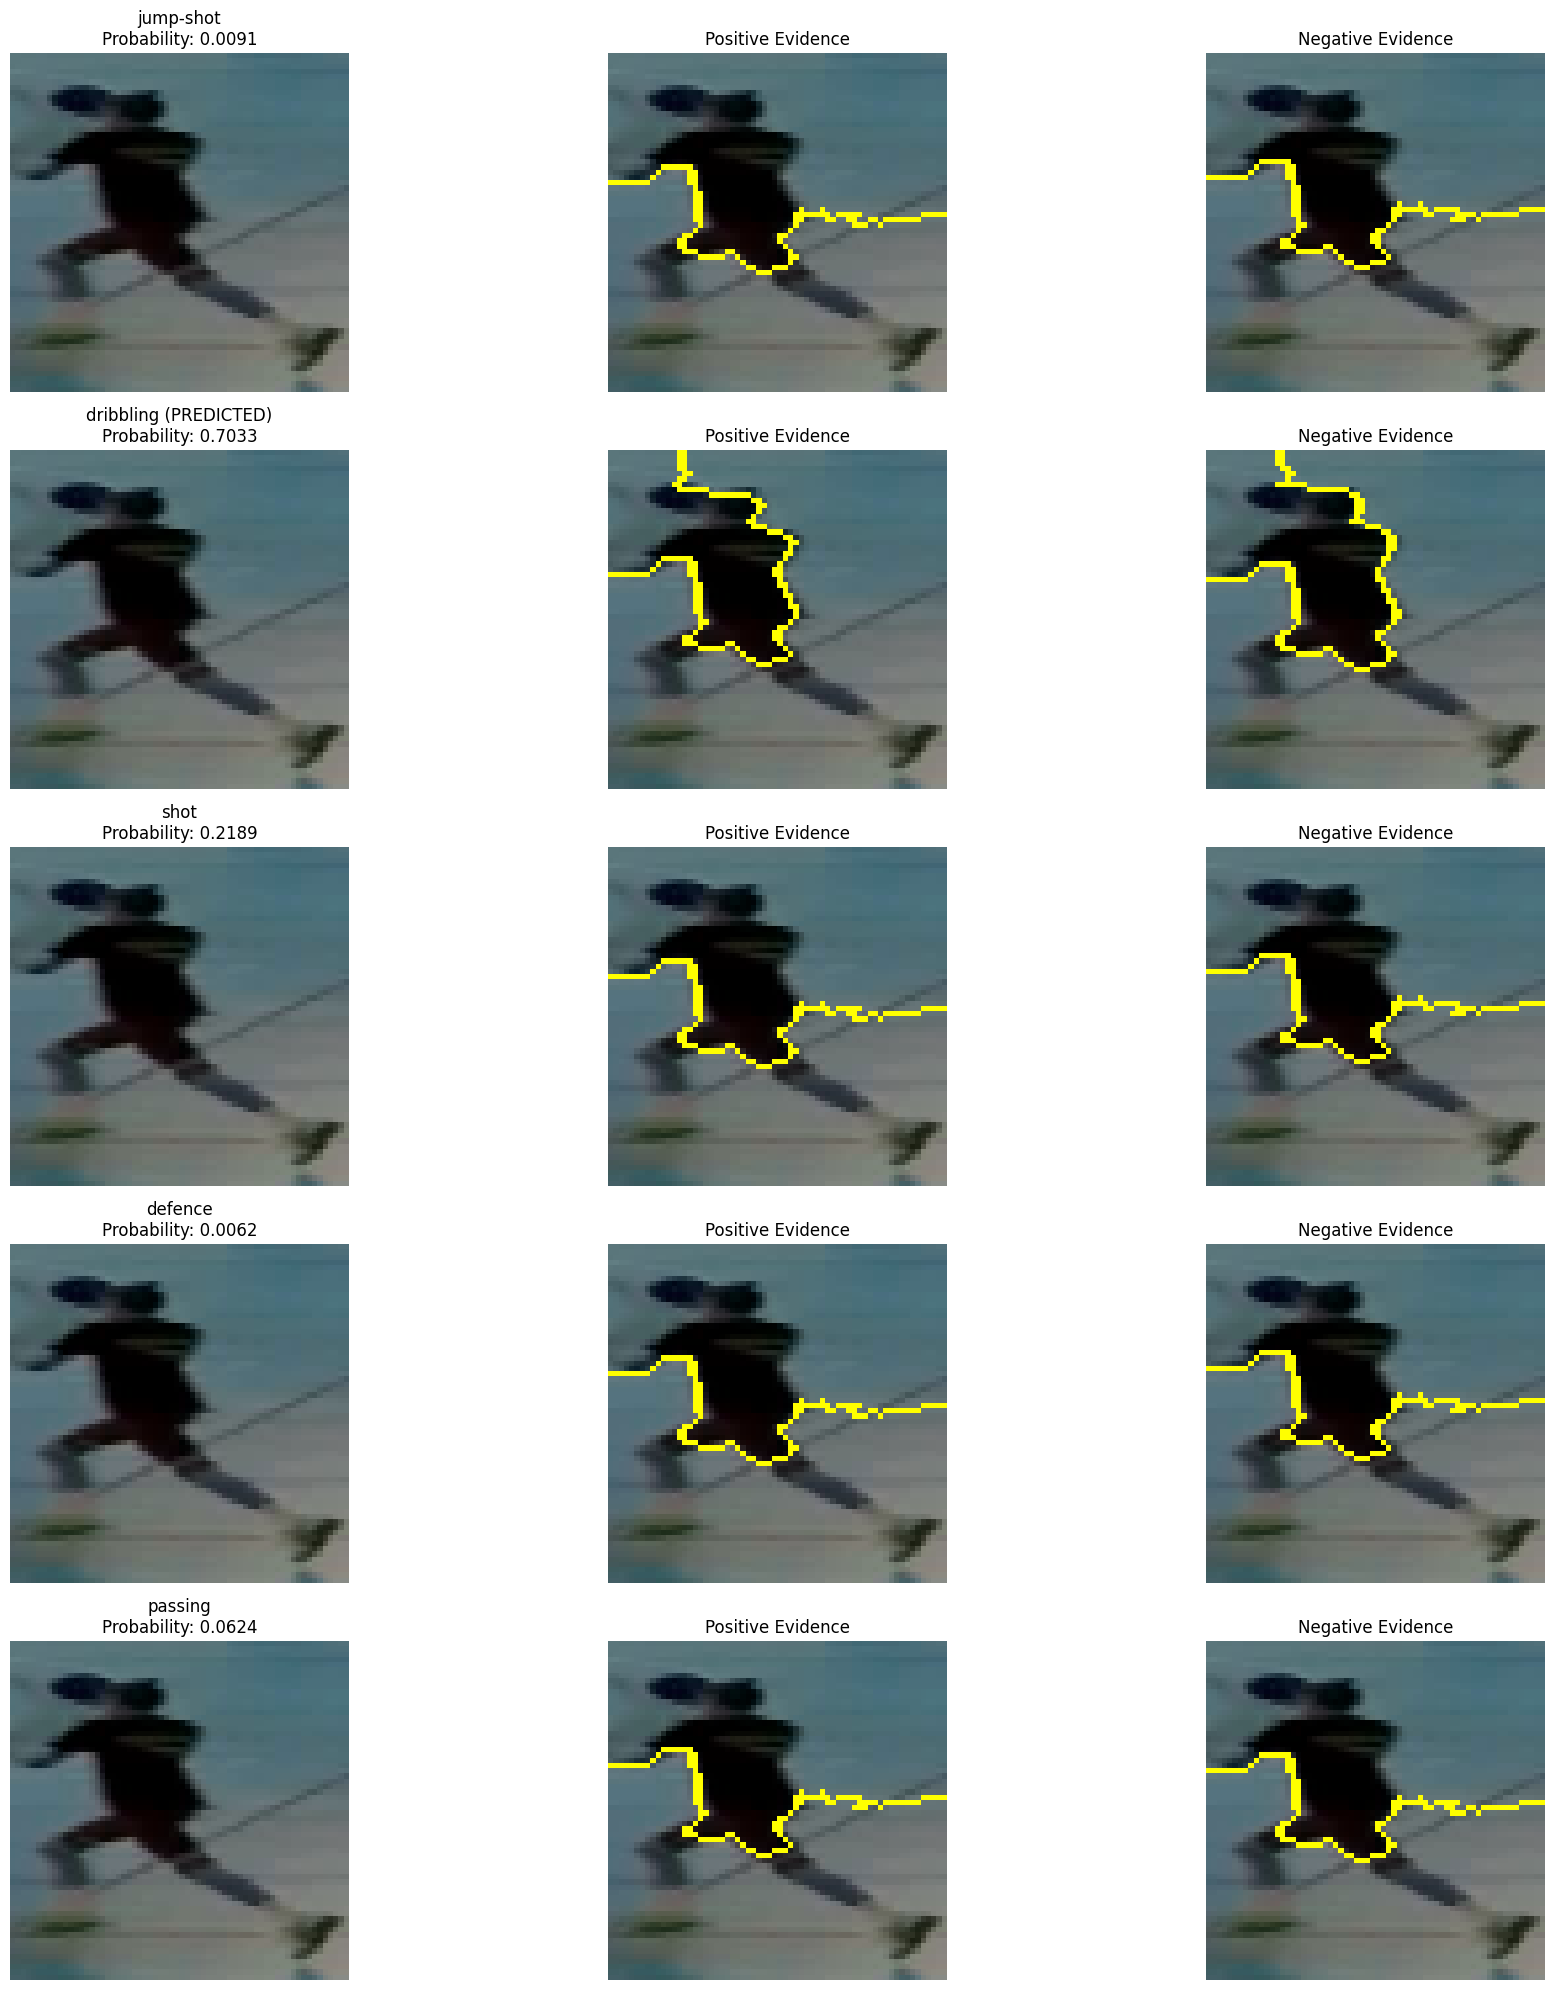

In [ ]:
def explain_with_lime():
    """
    Use LIME to explain handball action recognition predictions.
    """
    # First, install lime if you haven't already
    try:
        import lime
    except ImportError:
        print("Installing LIME...")
        !pip install lime
        import lime

    from lime import lime_image
    from skimage.segmentation import mark_boundaries

    # 1. Load a sample video frame
    video_path = '/content/drive/MyDrive/handball_project2/actions_2/track831_classdribbling.avi'
    video = cv2.VideoCapture(video_path)
    success, frame = video.read()
    video.release()

    if not success:
        print("Failed to read video")
        return

    # 2. Preprocess the frame
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255.0  # Values between 0-1

    # 3. Create a wrapper function for LIME
    def predict_fn(images):
        """
        Function that takes a batch of images and returns predictions.
        LIME requires this function to work with a batch of perturbed images.
        """
        # Preprocess images for model input
        processed_images = []
        for img in images:
            # LIME sometimes sends images with values outside [0,1]
            img = np.clip(img, 0, 1)
            processed_images.append(img)

        # Create sequences by duplicating each image
        batch_size = len(processed_images)
        sequences = np.zeros((batch_size, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))

        for i, img in enumerate(processed_images):
            sequences[i] = np.array([img] * SEQUENCE_LENGTH)

        # Get model predictions
        predictions = LRCN_model.predict(sequences)
        return predictions

    # 4. Create explainer
    explainer = lime_image.LimeImageExplainer()

    # 5. Get original prediction to find the top class
    sequence = np.array([normalized_frame] * SEQUENCE_LENGTH)
    sequence = np.expand_dims(sequence, axis=0)
    prediction = LRCN_model.predict(sequence)[0]
    top_class = np.argmax(prediction)
    class_name = CLASSES_LIST[top_class]
    confidence = prediction[top_class]

    print(f"Explaining prediction: {class_name} with confidence {confidence:.4f}")

    # 6. Generate explanation
    print("Generating LIME explanation (this may take a minute)...")
    explanation = explainer.explain_instance(
        normalized_frame,
        predict_fn,
        top_labels=len(CLASSES_LIST),
        hide_color=0,
        num_samples=1000,
        random_seed=42
    )

    # 7. Visualize the explanations for all classes
    plt.figure(figsize=(20, 4 * len(CLASSES_LIST)))

    for idx, label in enumerate(range(len(CLASSES_LIST))):
        class_name = CLASSES_LIST[label]
        class_prob = prediction[label]

        # Get explanation for this class
        temp, mask = explanation.get_image_and_mask(
            label,
            positive_only=True,  # Show only positive contributions
            num_features=10,     # Number of superpixels to include
            hide_rest=False      # Show the rest of the image
        )

        # Get negative contributions too
        temp_neg, mask_neg = explanation.get_image_and_mask(
            label,
            positive_only=False,  # Show positive and negative
            negative_only=True,   # Only show negative
            num_features=10,      # Number of superpixels to include
            hide_rest=False       # Show the rest of the image
        )

        # Plot the original image
        plt.subplot(len(CLASSES_LIST), 3, idx*3+1)
        plt.imshow(normalized_frame)
        if label == top_class:
            plt.title(f"{class_name} (PREDICTED)\nProbability: {class_prob:.4f}")
        else:
            plt.title(f"{class_name}\nProbability: {class_prob:.4f}")
        plt.axis('off')

        # Plot positive contributions
        plt.subplot(len(CLASSES_LIST), 3, idx*3+2)
        plt.imshow(mark_boundaries(temp, mask))
        plt.title("Positive Evidence")
        plt.axis('off')

        # Plot negative contributions
        plt.subplot(len(CLASSES_LIST), 3, idx*3+3)
        plt.imshow(mark_boundaries(temp_neg, mask_neg))
        plt.title("Negative Evidence")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('handball_lime_explanation.png', dpi=200)
    plt.show()

    # 8. Return explanation object
    return explanation

# Call the function to run LIME
lime_explanation = explain_with_lime()

In [ ]:
from tensorflow.keras.models import load_model

# Path to your trained model
model_path = "/content/drive/MyDrive/LRCN_models/LRCN_model__Date_Time_2025_04_29__21_17_47__Loss_0.39231064915657043__Accuracy_0.8394160866737366.h5"
LRCN_model = load_model(model_path)
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [ ]:
# Run evaluation
evaluation_metrics = LRCN_model.evaluate(features_test, labels_test, verbose=1)

print(f"🔍 Test Loss: {evaluation_metrics[0]:.4f}")
print(f"🎯 Test Accuracy: {evaluation_metrics[1]:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8219 - loss: 0.4347
🔍 Test Loss: 0.3923
🎯 Test Accuracy: 0.8394


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step


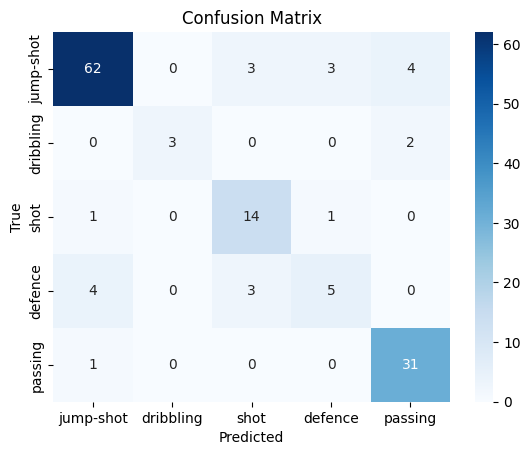

              precision    recall  f1-score   support

   jump-shot       0.91      0.86      0.89        72
   dribbling       1.00      0.60      0.75         5
        shot       0.70      0.88      0.78        16
     defence       0.56      0.42      0.48        12
     passing       0.84      0.97      0.90        32

    accuracy                           0.84       137
   macro avg       0.80      0.74      0.76       137
weighted avg       0.84      0.84      0.84       137



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = LRCN_model.predict(features_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(labels_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=CLASSES_LIST))



              precision    recall  f1-score   support

   jump-shot       0.91      0.86      0.89        72
   dribbling       1.00      0.60      0.75         5
        shot       0.70      0.88      0.78        16
     defence       0.56      0.42      0.48        12
     passing       0.84      0.97      0.90        32

    accuracy                           0.84       137
   macro avg       0.80      0.74      0.76       137
weighted avg       0.84      0.84      0.84       137



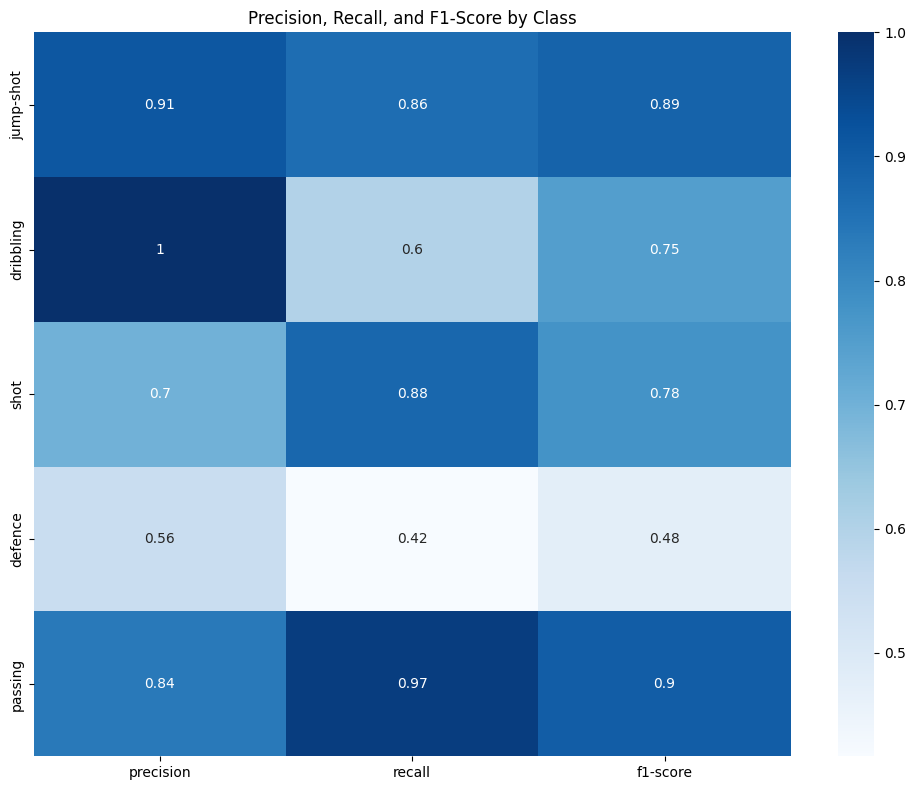

In [ ]:
from sklearn.metrics import classification_report

# Generate and print classification report
report = classification_report(y_true, y_pred_classes,
                              target_names=CLASSES_LIST,
                              output_dict=True)

# Print report
print(classification_report(y_true, y_pred_classes, target_names=CLASSES_LIST))

# Visualize as a heatmap
import pandas as pd
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 8))
sns.heatmap(report_df.iloc[:-3, :3].astype(float), annot=True, cmap='Blues')
plt.title('Precision, Recall, and F1-Score by Class')
plt.tight_layout()
plt.savefig('class_metrics.png')
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Top-1 Accuracy: 0.8394
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Top-2 Accuracy: 0.9416
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Top-3 Accuracy: 0.9854


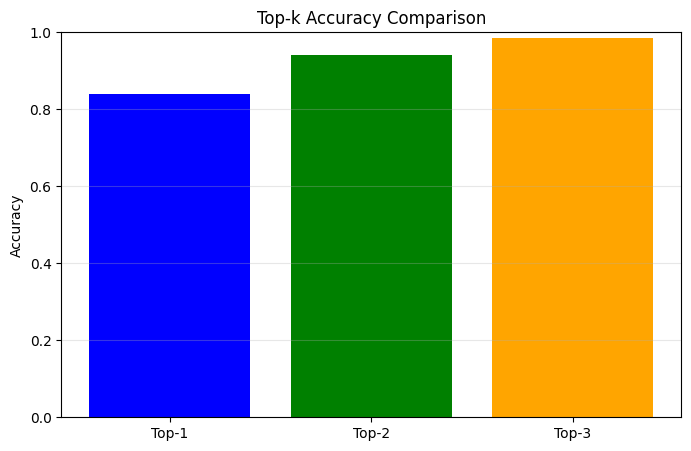

In [ ]:
def compute_top_k_accuracy(model, features, labels, k=2):
    """
    Compute top-k accuracy - whether the true label is in the top k predictions.
    """
    # Convert one-hot labels to class indices
    true_labels = np.argmax(labels, axis=1)

    # Get model predictions
    predictions = model.predict(features)

    # Get top k predicted classes for each sample
    top_k_pred = np.argsort(predictions, axis=1)[:, -k:]

    # Check if true label is in top k predictions for each sample
    matches = [true_labels[i] in top_k_pred[i] for i in range(len(true_labels))]

    # Compute accuracy
    top_k_accuracy = sum(matches) / len(matches)

    print(f"Top-{k} Accuracy: {top_k_accuracy:.4f}")

    return top_k_accuracy

# Example usage
top_1_acc = compute_top_k_accuracy(LRCN_model, features_test, labels_test, k=1)
top_2_acc = compute_top_k_accuracy(LRCN_model, features_test, labels_test, k=2)
top_3_acc = compute_top_k_accuracy(LRCN_model, features_test, labels_test, k=3)

# Plot results
plt.figure(figsize=(8, 5))
plt.bar(['Top-1', 'Top-2', 'Top-3'], [top_1_acc, top_2_acc, top_3_acc],
        color=['blue', 'green', 'orange'])
plt.ylim([0, 1.0])
plt.ylabel('Accuracy')
plt.title('Top-k Accuracy Comparison')
plt.grid(axis='y', alpha=0.3)
plt.savefig('top_k_accuracy.png')
plt.show()